This notebook was used to reproduce figure 1 of report. Due to size of CIFAR dataset, this takes hours to run on a local machine. 

### Get plots on multiclass logistic regression on CIFAR-10.

In [2]:
import jax
import jax.numpy as jnp
import jax.random as jr
from jax import grad
import matplotlib.pyplot as plt
import torch, torchvision
import torchvision.transforms as T
import numpy as np
from tqdm.auto import tqdm

from optimizers.mrcg import (
    scaling_selection as mrcg_scaling_selection,
    backtracking_LS   as mrcg_backtracking,
    forward_backward_LS as mrcg_forwardback,
)

### 1. Data and Hyperparameters

In [3]:
def load_cifar10_flatten():
    tfm = T.Compose([T.ToTensor()])
    ds  = torchvision.datasets.CIFAR10(root="~/.torch/datasets",
                                       train=True, download=True, transform=tfm)
    X = torch.stack([x.view(-1) for x, _ in ds]).numpy()          # (50k,3072)
    y = torch.tensor([lbl for _, lbl in ds]).numpy()              # (50k,)
    X = (X - X.mean(0, keepdims=True)) / (X.std(0, keepdims=True) + 1e-6)
    X = np.concatenate([X, np.ones((X.shape[0],1))], axis=1)      # +bias feat
    return X.astype(np.float32), y.astype(np.int32)

X_np, y_np = load_cifar10_flatten()
N, d = X_np.shape
C     = 10
print(f"Loaded CIFAR-10: X {X_np.shape}, y {y_np.shape}")

# one-hot for *all* 10 classes  (→ first loss = ln 10)
Y_onehot = (y_np[:,None] == np.arange(C)[None,:]).astype(np.float32)

# JAX arrays
X, Y = jnp.asarray(X_np), jnp.asarray(Y_onehot)

lambda_ = 1e-3
sigma, theta, rho = 0.0, 0.5, 1e-4
key = jr.PRNGKey(42)

Loaded CIFAR-10: X (50000, 3073), y (50000,)


### 2. Define oracle counting identical to report

In [4]:
def f_raw(params):
    """params shape (d*(C-1),) for classes 0…8; class-9 weights are zero."""
    W = params.reshape(d, C-1)                 # (d,9)
    logits  = X @ W                            # (N,9)
    ref_col = jnp.zeros((N,1))                 # class-9 logits = 0
    full_logits = jnp.concatenate([logits, ref_col], axis=1)  # (N,10)

    log_probs = full_logits - jax.scipy.special.logsumexp(
                                full_logits, axis=1, keepdims=True)
    ce  = -jnp.mean(jnp.sum(Y * log_probs, axis=1))            # NOTE: no slice
    reg = 0.5 * lambda_ * jnp.sum(params**2)
    return ce + reg

oracle_calls = 0
def f_counted(p):   # +1
    global oracle_calls
    oracle_calls += 1
    return f_raw(p)

def grad_count(p):  # f +1 already, add +1 here  ⇒ 2 total
    global oracle_calls
    oracle_calls += 1
    return grad(f_counted)(p)

def hvp_count(p,v): # f+g already, add +2 here  ⇒ 4 total
    global oracle_calls
    oracle_calls += 2
    return jax.jvp(grad(f_counted), (p,), (v,))[1]


### 3. Optimizer steps

In [11]:
def mrcg_step(state):
    params, key = state
    key, sk = jr.split(key)

    g = grad_count(params)
    p, flag = mrcg_scaling_selection(
        g, lambda p,_: f_counted(p), params, sigma, sk,
        hv_fun=lambda p,v: hvp_count(p,v)
    )

    if flag in ("SPC","LPC"):
        alpha = mrcg_backtracking(lambda p,_: f_counted(p), sk, theta, rho,
                              params, g, p)
    else:
        alpha = mrcg_forwardback(lambda p,_: f_counted(p), sk, theta, rho,
                             params, g, p)
    return (params + alpha*p, key)

### 4. Run it

In [12]:
state = (jnp.zeros(d*(C-1), jnp.float32), key)
MAX_CALLS, GRAD_TOL = 100_000, 1e-4
obj, orc = [], []

oracle_calls = 0
obj = [f_counted(state[0])]   # <-- NEW  log f(θ₀)       (+1 oracle call)
orc = [oracle_calls]

bar = tqdm(total=MAX_CALLS, desc="Oracle calls", unit="call", dynamic_ncols=True)
while oracle_calls < MAX_CALLS:
    oc_prev = oracle_calls
    state   = mrcg_step(state)
    f_val   = f_counted(state[0])               # +1
    g_norm  = jnp.linalg.norm(grad_count(state[0]))  # +1
    obj.append(f_val); orc.append(oracle_calls)
    bar.update(oracle_calls - oc_prev)
    if g_norm <= GRAD_TOL: break
bar.close()

print(f"Stopped after {oracle_calls} calls; final ‖g‖={float(g_norm):.2e}")

Oracle calls:   0%|          | 0/100000 [00:00<?, ?call/s]

Stopped after 100003 calls; final ‖g‖=2.36e-03


### 5. Plot

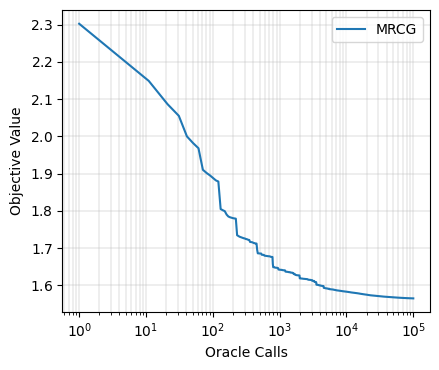

In [43]:
import matplotlib.ticker as mtick
fig, ax = plt.subplots(figsize=(4.5,3.8))
ax.set_xscale("log")
ax.plot(orc, obj, label="MRCG")
ax.yaxis.set_major_formatter(mtick.ScalarFormatter(useMathText=True))
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.set_xlabel("Oracle Calls"); ax.set_ylabel("Objective Value")
ax.grid(True, which="both", lw=0.3); ax.legend()
fig.tight_layout()
fig.savefig("mrcg_cifar10_curve.png", dpi=150)
plt.show()


### Comparison to other optimizers

#### HB Method

In [ ]:
oracle_calls = 0
mu_approx = lambda_
fro2      = jnp.sum(X**2)
L_approx  = (C-1) / (4*N) * fro2 + lambda_

alpha_hb = 4.0 / ( (jnp.sqrt(L_approx) + jnp.sqrt(mu_approx))**2 )
beta_hb  = ((jnp.sqrt(L_approx) - jnp.sqrt(mu_approx)) /
            (jnp.sqrt(L_approx) + jnp.sqrt(mu_approx)))**2
print(f"HB settings: α = {float(alpha_hb):.3e}, β = {float(beta_hb):.3f}")

params_hb = jnp.zeros(d*(C-1), jnp.float32)
v_hb      = jnp.zeros_like(params_hb)

MAX_CALLS, GRAD_TOL = 100_000, 1e-4

# ---- log initial point (1 oracle call) ---------------------------------
f0_hb  = f_counted(params_hb)    
orc_hb = [oracle_calls]         
obj_hb = [f0_hb]

bar = tqdm(total=MAX_CALLS, desc="HB Oracle calls", unit="call", dynamic_ncols=True)
while oracle_calls < MAX_CALLS:
    oc_prev = oracle_calls

    g = grad_count(params_hb)                       # +2 calls
    v_hb = beta_hb * v_hb + g
    params_hb = params_hb - alpha_hb * v_hb

    f_val  = f_counted(params_hb)                   # +1 call
    g_norm = jnp.linalg.norm(grad_count(params_hb)) # +2 calls
    obj_hb.append(f_val);  orc_hb.append(oracle_calls)

    bar.update(oracle_calls - oc_prev)
    if g_norm <= GRAD_TOL: break
bar.close()
print(f"HB stopped after {oracle_calls} calls; final ‖g‖ = {float(g_norm):.2e}")


HB settings: α = 5.781e-04, β = 0.998


HB Oracle calls:   0%|          | 0/100000 [00:00<?, ?call/s]

HB stopped after 100001 calls; final ‖g‖ = 2.89e-03


In [9]:
# Save results
np.savetxt("hb_cifar10_obj.txt", np.array(obj_hb))
np.savetxt("hb_cifar10_orc.txt", np.array(orc_hb))

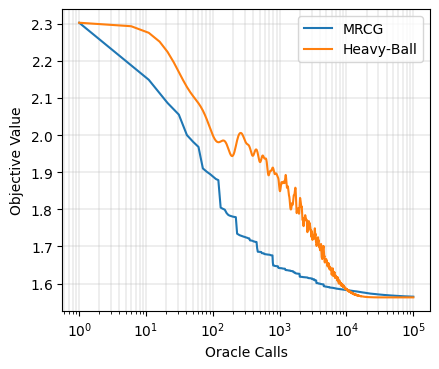

In [ ]:
import matplotlib.ticker as mtick
fig, ax = plt.subplots(figsize=(4.5,3.8))
ax.set_xscale("log")
ax.plot(orc, obj, label="MRCG")
ax.plot(orc_hb, obj_hb, label="Heavy‑Ball")
ax.yaxis.set_major_formatter(mtick.ScalarFormatter(useMathText=True))
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.set_xlabel("Oracle Calls"); ax.set_ylabel("Objective Value")
ax.grid(True, which="both", lw=0.3); ax.legend()
fig.tight_layout()
fig.savefig("mrcg_hb_cifar10_curve.png", dpi=150)
plt.show()

#### Fixed Method

In [ ]:
oracle_calls = 0
params0 = jnp.zeros(d * (C - 1), jnp.float32)
mu_approx = lambda_
fro2      = jnp.sum(X**2)
L_approx  = (C-1) / (4*N) * fro2 + lambda_
alpha_gd = 1.0 / L_approx
print(f"GD step size α = {float(alpha_gd):.3e}")

# 2. log initial point (one counted forward pass) ------------------------
f0_gd = f_counted(params0)          
orc_gd = [oracle_calls]             
obj_gd = [f0_gd]

key_gd = jr.PRNGKey(7)
MAX_CALLS = 100_000

bar = tqdm(total=MAX_CALLS, desc="GD oracle calls", unit="call",
           dynamic_ncols=True, leave=False)

while oracle_calls < MAX_CALLS:
    oc_prev = oracle_calls

    g = grad_count(params0)          # g  ← gradient vector
    params0 = params0 - alpha_gd * g

    f_val = f_counted(params0)       # +1 call
    obj_gd.append(f_val); orc_gd.append(oracle_calls)

    if jnp.linalg.norm(g) <= 1e-4:   # reuse g, no extra calls
        break

    bar.update(oracle_calls - oc_prev)

print(f"GD stopped after {oracle_calls} total oracle calls; "
      f"final loss = {float(obj_gd[-1]):.4f}")


GD step size α = 1.446e-04


GD oracle calls:   0%|          | 0/100000 [00:00<?, ?call/s]

GD stopped after 100000 total oracle calls; final loss = 1.7108


Saved ➜ mrcg_hb_nes_gd_cifar10_curve.png


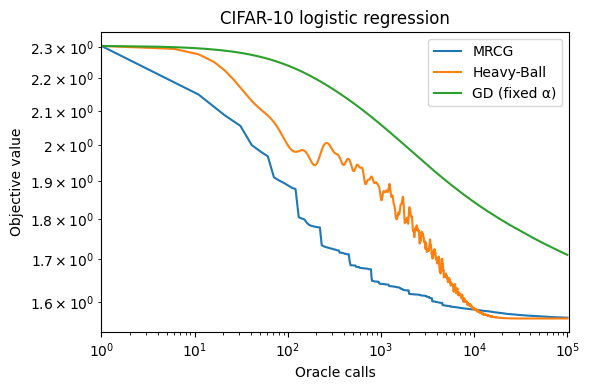

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(orc,     obj,     label='MRCG')
plt.plot(orc_hb,  obj_hb,  label='Heavy-Ball')
plt.plot(orc_gd,  obj_gd,  label='GD (fixed α)')
plt.xlim(left=1)          # optional – never plot x<1 on a log axis

plt.xscale('log'); plt.yscale('log')
plt.xlabel('Oracle calls'); plt.ylabel('Objective value')
plt.title('CIFAR-10 logistic regression')
plt.legend(); plt.tight_layout()

plt.savefig('mrcg_hb_nes_gd_cifar10_curve.png', dpi=300)
print('Saved ➜ mrcg_hb_nes_gd_cifar10_curve.png')


#### Line Search Method

In [ ]:
from optimizers.LS_GD import ls_init, ls_step
import jax.random as jr
oracle_calls = 0
rho_ls   = 1e-4        
theta_ls = 0.5       
MAX_CALLS = 100_000
GRAD_TOL  = 1e-4

# ---------- counted loss wrapper -----------------------------
loss_counted = lambda p, k: f_counted(p)   # +1 forward pass

# ---------- initial state & first log ------------------------
params_ls = jnp.zeros(d * (C - 1), jnp.float32)
key_ls    = jr.PRNGKey(2024)

state_ls = ls_init(params_ls, loss_counted, key_ls,
                   rho=rho_ls, theta=theta_ls)

f0_ls  = loss_counted(state_ls.params, state_ls.key)   
orc_ls = [oracle_calls]                                
obj_ls = [f0_ls]

bar = tqdm(total=MAX_CALLS, desc="LS-GD oracle calls", unit="call",
           dynamic_ncols=True, leave=False)

while oracle_calls < MAX_CALLS:
    oc_prev = oracle_calls

    state_ls = ls_step(state_ls)
    oracle_calls += 1          

    loss_val = loss_counted(state_ls.params, state_ls.key)
    obj_ls.append(loss_val);  orc_ls.append(oracle_calls)

    g = grad_count(state_ls.params)     
    if jnp.linalg.norm(g) <= GRAD_TOL:
        break

    bar.update(oracle_calls - oc_prev)
bar.close()

print(f"Line-search GD stopped at {oracle_calls} oracle calls; "
      f"final loss = {float(obj_ls[-1]):.4f}")


LS-GD oracle calls:   0%|          | 0/100000 [00:00<?, ?call/s]

Line-search GD stopped at 100010 oracle calls; final loss = 1.5838


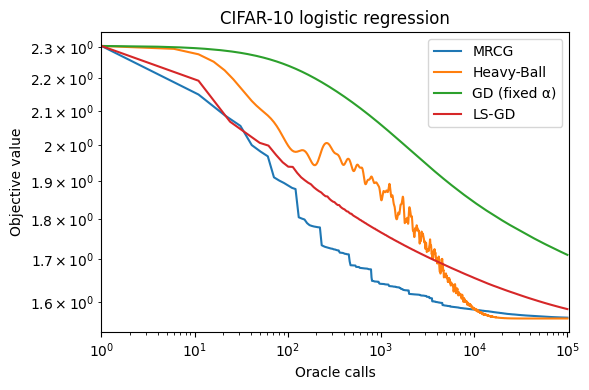

In [11]:
plt.figure(figsize=(6, 4))
plt.plot(orc,     obj,     label='MRCG')
plt.plot(orc_hb,  obj_hb,  label='Heavy-Ball')
plt.plot(orc_gd,  obj_gd,  label='GD (fixed α)')
plt.plot(orc_ls,  obj_ls,  label='LS-GD')
plt.xlim(left=1)          # optional – never plot x<1 on a log axis

plt.xscale('log'); plt.yscale('log')
plt.xlabel('Oracle calls'); plt.ylabel('Objective value')
plt.title('CIFAR-10 logistic regression')
plt.legend(); plt.tight_layout()

#### Adam Method

In [ ]:
from optimizers.adam import adam_init, adam_step
import jax, jax.numpy as jnp, jax.random as jr

oracle_calls = 0

adam_lr = 1e-3
beta1, beta2, eps = 0.9, 0.999, 1e-8
MAX_CALLS = 100_000
GRAD_TOL  = 1e-4

# ---------- counted loss wrapper ------------------------------
loss_at_params = lambda p, k: f_counted(p)   # adds +1 forward call

# ---------- initial state & first log -------------------------
params0 = jnp.zeros(d * (C - 1), jnp.float32)
key_adam = jr.PRNGKey(0)

state_adam = adam_init(params0, loss_at_params,
                       lr=adam_lr, key=key_adam,
                       beta1=beta1, beta2=beta2, eps=eps)

f0_adam = loss_at_params(state_adam.params, state_adam.key) 
orc_adam = [oracle_calls]   
obj_adam = [f0_adam]

# ---------- optimisation loop ---------------------------------
bar = tqdm(total=MAX_CALLS, desc="Adam oracle calls", unit="call",
           dynamic_ncols=True, leave=False)

while oracle_calls < MAX_CALLS:
    oc_prev = oracle_calls

    state_adam = adam_step(state_adam)    
    oracle_calls += 1                     

    if state_adam.iteration % 10 == 0:
        loss_val = loss_at_params(state_adam.params, state_adam.key)
        obj_adam.append(loss_val)
        orc_adam.append(oracle_calls)

    if state_adam.iteration % 10 == 0:    
        g = jax.grad(loss_at_params)(state_adam.params, state_adam.key) 
        oracle_calls += 1                 
        if jnp.linalg.norm(g) <= GRAD_TOL:
            break

    bar.update(oracle_calls - oc_prev)
bar.close()

print(f"Adam stopped at {oracle_calls} oracle calls; "
      f"final loss = {float(obj_adam[-1]):.4f}")


Adam oracle calls:   0%|          | 0/100000 [00:00<?, ?call/s]

Adam stopped at 100000 oracle calls; final loss = 1.5635


In [ ]:
np.savetxt("mrcg_cifar10_obj.txt", np.array(obj))
np.savetxt("mrcg_cifar10_orc.txt", np.array(orc))

np.savetxt("adam_cifar10_obj.txt", np.array(obj_adam))
np.savetxt("adam_cifar10_orc.txt", np.array(orc_adam))

np.savetxt("ls_cifar10_obj.txt", np.array(obj_ls))
np.savetxt("ls_cifar10_orc.txt", np.array(orc_ls))

np.savetxt("hb_cifar10_obj.txt", np.array(obj_hb))
np.savetxt("hb_cifar10_orc.txt", np.array(orc_hb))

np.savetxt("gd_cifar10_obj.txt", np.array(obj_gd))
np.savetxt("gd_cifar10_orc.txt", np.array(orc_gd))

In [ ]:
import numpy as np
import jax, jax.numpy as jnp, jax.random as jr

orc = np.loadtxt("mrcg_cifar10_orc.txt")   
obj = np.loadtxt("mrcg_cifar10_obj.txt")   

orc = jnp.asarray(orc)
obj = jnp.asarray(obj)

orc_hb = np.loadtxt("hb_cifar10_orc.txt")   
obj_hb = np.loadtxt("hb_cifar10_obj.txt")   

orc_hb = jnp.asarray(orc_hb)
obj_hb = jnp.asarray(obj_hb)

orc_gd = np.loadtxt("gd_cifar10_orc.txt")   
obj_gd = np.loadtxt("gd_cifar10_obj.txt")   

orc_gd = jnp.asarray(orc_gd)
obj_gd = jnp.asarray(obj_gd)

orc_ls = np.loadtxt("ls_cifar10_orc.txt")   
obj_ls = np.loadtxt("ls_cifar10_obj.txt")   

orc_ls = jnp.asarray(orc_ls)
obj_ls = jnp.asarray(obj_ls)

orc_adam = np.loadtxt("adam_cifar10_orc.txt")   
obj_adam = np.loadtxt("adam_cifar10_obj.txt")   

orc_adam = jnp.asarray(orc_adam)
obj_adam = jnp.asarray(obj_adam)

Saved ➜ cifar10_curve.png


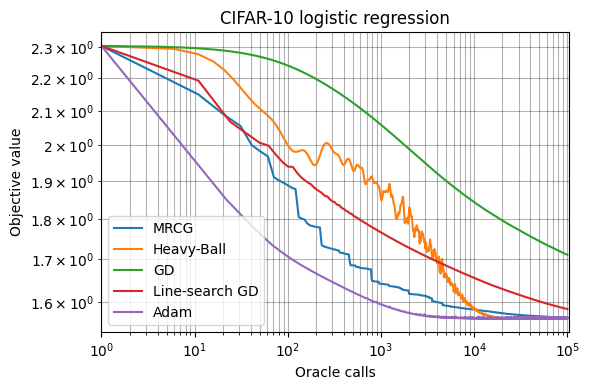

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(orc,     obj,     label='MRCG')
plt.plot(orc_hb,  obj_hb,  label='Heavy-Ball')
plt.plot(orc_gd,  obj_gd,  label='GD')
plt.plot(orc_ls,  obj_ls,  label='Line-search GD')
plt.plot(orc_adam, obj_adam, label='Adam')

plt.xlim(left=1)           
plt.xscale('log'); plt.yscale('log')
plt.xlabel('Oracle calls'); plt.ylabel('Objective value')
plt.title('CIFAR-10 logistic regression')
plt.legend()

ax = plt.gca()                  
ax.grid(True, which="both",
        color="black", linewidth=0.8, alpha=0.3)

plt.tight_layout()
plt.savefig("cifar10_curve.png", dpi=300)
print("Saved ➜ cifar10_curve.png")